In [86]:
import sys
sys.path.append("../battery_pack_v2/src/")

import pandas as pd
import os
import DyMat
import kissmodelica.postproc as pp
import numpy as np

import plotly.express as px

In [87]:
df_in = pd.read_csv("200_samples_Vdot_const.csv")

In [89]:
resdir = "res"

# this takes a while ...
if 1==0:
    data = []
    for r in df_in.to_dict(orient='records'):
        simid = r["simid"]
        mat_path = os.path.join(resdir, simid+"_res.mat")
        mat = DyMat.DyMatFile(mat_path)
        try:
            res = pp.extract_scalar_values2(mat, **r)
        except ValueError:
            res = {"simid": simid}
        data.append(res)
        
    df_res = pd.DataFrame(data)
    # save as csv
    df_res.to_csv("200_samples_Vdot_const_results.csv", index=False)
    
# read csv
df_res = pd.read_csv("200_samples_Vdot_const_results.csv")
# merge with input
dfr = pd.merge(df_in, df_res, on="simid")

In [110]:
MCELL = 0.137 # kg

# Per pack data

# warum 4? -> 4 kanäle.
# mass estimate for a plate: 4 * ncells * cell_width x ((2*t_cover + channel_height) x channel_dist - channel_height x channel_width)
dfr['mass_estimate_pack'] = dfr.nracks*dfr.ncells * (4*dfr.rho_plate*dfr.cell_width*((2*dfr.t_cover + dfr.channel_height)*dfr.channel_dist - 
                                                   dfr.channel_height * dfr.channel_width) + 2*MCELL)
dfr["m_flow_pack"] = dfr["m_flow"] * dfr["nracks"]
dfr["ar_channel"] = dfr["channel_width"] / dfr["channel_height"]
dfr["ar_channel_log"] = np.log(dfr["ar_channel"])
dfr["ncells_pack"] = 2 * dfr["ncells"] * dfr["nracks"]
dfr["dp_max_log"] = np.log(dfr.dp_max)
dfr["Re_log"] = np.log(dfr.Re)

# constraints: dp < .1 bar, t21 < 1000, Tmax < 45
dfr["satisfactory"] = (dfr.t21 <= 1000) & (dfr.dp_max <= 1e4) & (dfr.T_cellmax <= 273.15 + 50)


In [193]:
dfr.filter(items=cols_in).describe().T

count      mean       std       min       25%       50%  \
t_cover         201.0  0.001798  0.000738  0.000517  0.001136  0.001822   
ar_channel_log  201.0  1.361711  0.764592 -0.254606  0.793336  1.284768   
area_channel    201.0  0.000038  0.000025  0.000004  0.000017  0.000032   
ncells          201.0  9.059701  4.138408  4.000000  6.000000  8.000000   

                      75%        max  
t_cover          0.002473   0.002975  
ar_channel_log   1.897601   3.514416  
area_channel     0.000057   0.000107  
ncells          12.000000  18.000000

In [191]:
dfr.query("ncells==8").filter(items=cols_in + cols_res).head()

t_cover  ar_channel_log  area_channel  ncells  dp_max_log   T_cellmax  \
0   0.002000        0.693147      0.000032       8    5.191773  322.293687   
17  0.001135        1.088052      0.000049       8    4.504715  321.828526   
18  0.001595        2.092806      0.000021       8    6.829672  324.662479   
29  0.001610        0.944538      0.000080       8         NaN         NaN   
34  0.001604        1.021411      0.000064       8    3.924480  320.507104   

      t21  mass_estimate_pack  
0   745.0           29.357798  
17  752.0           26.559565  
18  716.0           25.450784  
29    NaN           28.818654  
34  776.0           28.306216

In [117]:
#- dp + Tmax
#- __dp - t21__
#- __Tmax - t21__
#- __Tmax - mass__
#- t21 + mass

cols = ['t_cover', 'channel_width', 'channel_height', 'nracks', 'ncells',
        'm_flow', 't_plate', 
       'simid', "satisfactory", "m_flow_pack",
       'dp_max_log', 'T_cellmax', 't21', 'tpeak',
       'T_cell1000', 'dhyd', 'Re', 'mass_estimate_pack']


fig = px.scatter(dfr, x="dp_max_log", y="T_cellmax", color='satisfactory', log_y=False,
                 color_discrete_sequence=["green", "red"],
                 hover_data={c:True for c in cols})
fig.show()

fig = px.scatter(dfr, x="dp_max_log", y="t21", color='satisfactory', log_y=False,
                 color_discrete_sequence=["green", "red"],
                 hover_data={c:True for c in cols})
fig.show()

fig = px.scatter(dfr, x="T_cellmax", y="t21", color='satisfactory', log_y=False,
                 color_discrete_sequence=["green", "red"],
                 hover_data={c:True for c in cols})
fig.show()

fig = px.scatter(dfr, x="T_cellmax", y="mass_estimate_pack", color='satisfactory', log_y=False,
                 color_discrete_sequence=["green", "red"],
                 hover_data={c:True for c in cols})
fig.show()

fig = px.scatter(dfr, x="t21", y="mass_estimate_pack", color='satisfactory', log_y=False,
                 color_discrete_sequence=["green", "red"],
                 hover_data={c:True for c in cols})
fig.show()

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



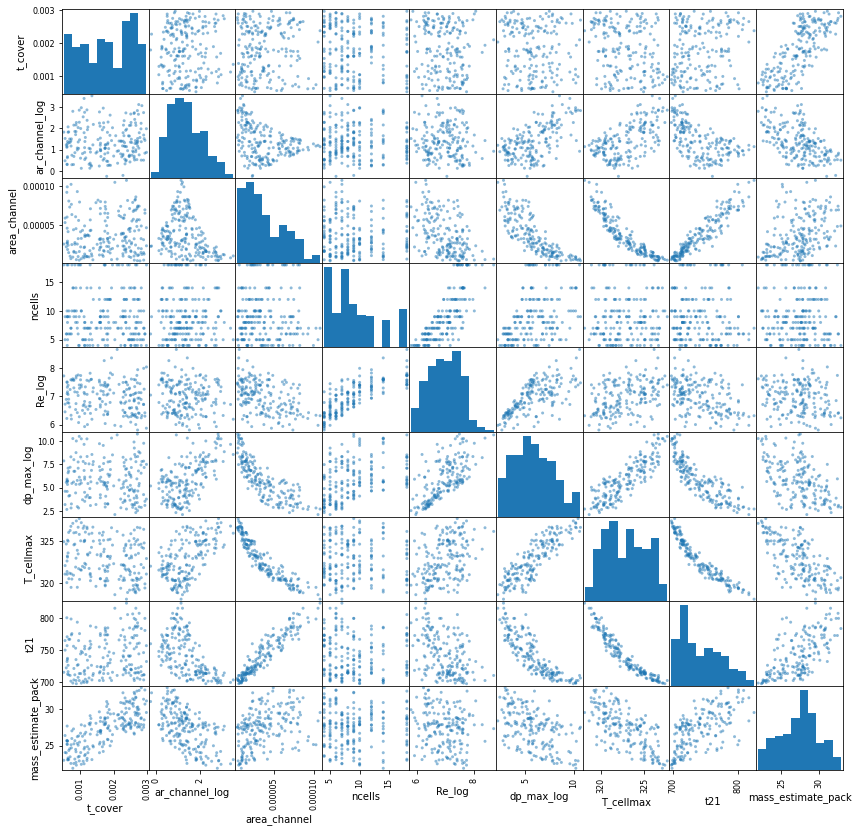

In [118]:
cols_sm = ['t_cover', 
           #'channel_width', 
           #'channel_height', 
           #'dhyd', 
           'ar_channel_log',
           'area_channel',
           'ncells', 
           #'m_flow_pack',  
           'Re_log', 
           'dp_max_log', 
           'T_cellmax', 't21', 
           #'T_cell1000', # no significant variation 
           'mass_estimate_pack'
          ]

pd.plotting.scatter_matrix(dfr.filter(items=cols_sm), figsize=(14,14));

In [95]:
cols_in = ['t_cover', 
           'ar_channel_log', 
           'area_channel', 
           #'dhyd', 
           #'ar_channel_log',
           #'area_channel',
           'ncells', 
           #'m_flow_pack',  
           #'Re_log'
          ]

cols_res = ['dp_max_log', 
           'T_cellmax', 't21', 
           #'T_cell1000', # no significant variation 
           'mass_estimate_pack'
          ]

## Correlations (> 0.6)

Design variables are: 
- tcover influences: mass (+)
- AR influences: mass (-)
- area influences: dp (-), Tmax (-), t21 (+)
- ncell influences: dp (+), but on a low level (< 0.6)

we want as objectives: 
- dp low
- Tmax low
- t21 low
- mass low

highly influential DV:
- mass: t_cover (+), AR (-)
- t21: area (+), 
- Tmax: area (-)
- dp: area (-)

strong correlation between objectives (negative correlation in __bold__):
- dp + Tmax
- __dp - t21__
- __Tmax - t21__
- __Tmax - mass__
- t21 + mass

In [119]:
dfr.filter(items=cols_in+cols_res).corr(method='spearman')

t_cover  ar_channel_log  area_channel    ncells  \
t_cover             1.000000        0.048640      0.039540 -0.071039   
ar_channel_log      0.048640        1.000000     -0.382070 -0.001509   
area_channel        0.039540       -0.382070      1.000000 -0.057239   
ncells             -0.071039       -0.001509     -0.057239  1.000000   
dp_max_log         -0.079088        0.552474     -0.870558  0.445511   
T_cellmax          -0.240943        0.550877     -0.959383  0.015706   
t21                 0.169847       -0.611922      0.947855 -0.086363   
mass_estimate_pack  0.741476       -0.552494      0.448844 -0.028327   

                    dp_max_log  T_cellmax       t21  mass_estimate_pack  
t_cover              -0.079088  -0.240943  0.169847            0.741476  
ar_channel_log        0.552474   0.550877 -0.611922           -0.552494  
area_channel         -0.870558  -0.959383  0.947855            0.448844  
ncells                0.445511   0.015706 -0.086363           -0.028327  
dp_max_log            1.000000   0.856639 -0.893183           -0.520622  
T_cellmax             0.856639   1.000000 -0.977084           -0.681916  
t21                  -0.893183  -0.977084  1.000000            0.669587  
mass_estimate_pack   -0.520622  -0.681916  0.669587            1.000000

## feature importances

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import scikitplot as skplt

In [183]:
## Feature Importances
cols_fi = ['t_cover', 'channel_width', 'channel_height', 'nracks', 'ncells',
           'm_flow', 'area_channel', 'ar_channel', 'v',
           'Re', 'ar_channel_log',]

cols_fi = ['t_cover', 'channel_width', 'channel_height', 'nracks']

cols_fi = ['t_cover', 'ar_channel', 'area_channel', 'nracks', 'Re', 'm_flow']

In [184]:
df_train, df_test = train_test_split(dfr.dropna())
X = df_train.filter(items=cols_fi)

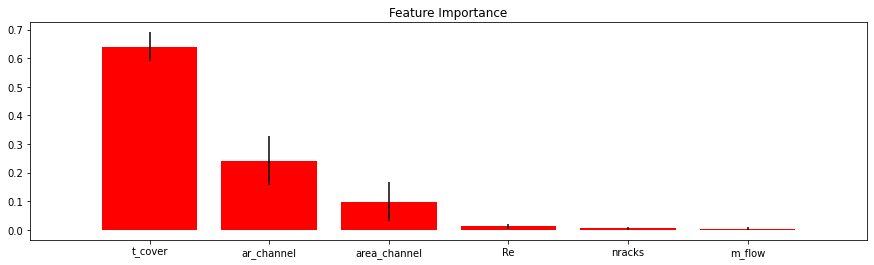

In [185]:
rf = RandomForestRegressor()
rf.fit(X, df_train['mass_estimate_pack'])
skplt.estimators.plot_feature_importances(rf, feature_names=cols_fi, figsize=(15,4));

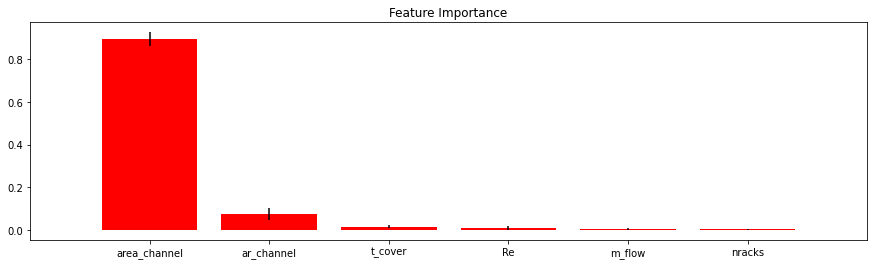

In [186]:
rf = RandomForestRegressor()
rf.fit(X, df_train['t21'])
skplt.estimators.plot_feature_importances(rf, feature_names=cols_fi, figsize=(15,4));

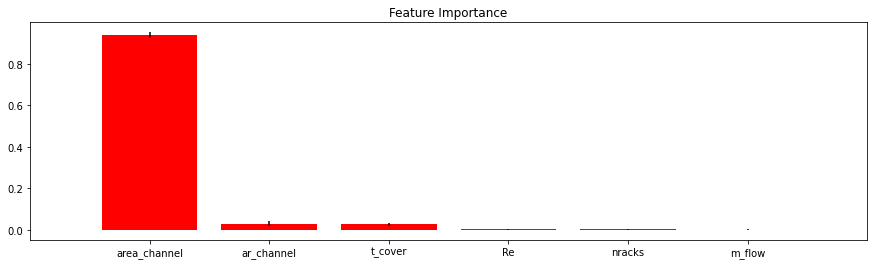

In [187]:
rf = RandomForestRegressor()
rf.fit(X, df_train['T_cellmax'])
skplt.estimators.plot_feature_importances(rf, feature_names=cols_fi, figsize=(15,4));

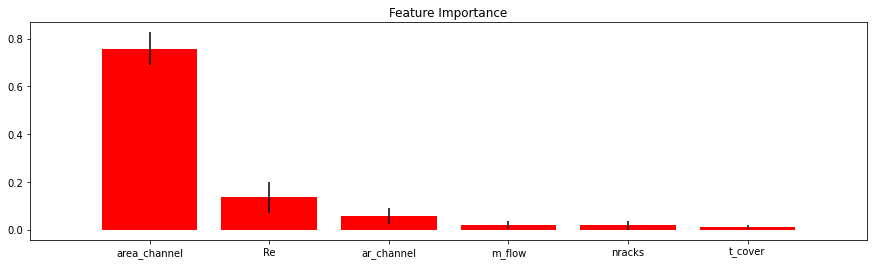

In [188]:
rf = RandomForestRegressor()
rf.fit(X, df_train['dp_max_log'])
skplt.estimators.plot_feature_importances(rf, feature_names=cols_fi, figsize=(15,4));

## Designs that are better than baseline in all aspects

- Index 0 = Baseline
- __Keine ausreichende Basis für finale Schlüsse.__
- nur startpunkt für Einengung des Suchraums.


- cover thickness reduced only in one case. strange (possible reason: not enough samples)
- aspect ratio often higher (more direct heat transfer into water)
- channel area always slightly higher
- more racks, less racks per cell -> more short channels cool better than few long channels)
- Reynolds number and v always lower (makes sense because of higher cross section). 
  Re always in laminar region.

In [219]:
baseline = dfr.loc[0]

imass = dfr.mass_estimate_pack <= baseline.mass_estimate_pack
itmax = dfr.T_cellmax <= baseline.T_cellmax
it21 = dfr.t21 <= baseline.t21
idp = dfr.dp_max <= baseline.dp_max

cols_best = ['t_cover', 'channel_width', 'channel_height', 'nracks', 'ncells', 'ar_channel', 'area_channel',
            'dp_max', 'T_cellmax', 't21', 'v', 'dhyd', 'Re', 'mass_estimate_pack']

dfr[imass & itmax & it21 & idp].filter(items=cols_best).T

0           81          91          102  \
t_cover                0.002000    0.002226    0.002291    0.002441   
channel_width          0.008000    0.012355    0.018373    0.015136   
channel_height         0.004000    0.003095    0.002157    0.002934   
nracks                 9.000000   10.000000   12.000000   14.000000   
ncells                 8.000000    7.000000    6.000000    5.000000   
ar_channel             2.000000    3.991265    8.517013    5.159078   
area_channel           0.000032    0.000038    0.000040    0.000044   
dp_max               179.786986  137.499555  155.776014   61.293041   
T_cellmax            322.293687  322.161246  322.154544  321.643799   
t21                  745.000000  733.000000  739.000000  741.000000   
v                      0.115949    0.087321    0.070210    0.053715   
dhyd                   0.010667    0.009901    0.007722    0.009830   
Re                  1232.103694  861.282175  540.124078  526.011879   
mass_estimate_pack    29.357798   27.750414   27.416411   27.898819   

                           129         141  
t_cover               0.002468    0.001171  
channel_width         0.015270    0.008149  
channel_height        0.002993    0.004437  
nracks               10.000000   14.000000  
ncells                7.000000    5.000000  
ar_channel            5.101117    1.836431  
area_channel          0.000046    0.000036  
dp_max              112.514839   55.074609  
T_cellmax           321.472227  322.207004  
t21                 740.000000  743.000000  
v                     0.073056    0.065965  
dhyd                  0.010011    0.011492  
Re                  728.602202  755.178591  
mass_estimate_pack   28.004343   26.819444